In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import LSTM, Dense
from keras.layers import GRU 
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [2]:
exchange_data = pd.read_csv('GBPUSD-4HOUR.csv')
exchange_data.head()

,time,open,high,low,close,Volume,Volume MA
0,2009-12-31T22:00:00Z,1.617570,1.617570,1.615630,1.615630,8,NaN
1,2010-01-03T22:00:00Z,1.611220,1.615290,1.609180,1.609230,4115,NaN
2,2010-01-04T02:00:00Z,1.609230,1.612080,1.607350,1.609630,2782,NaN
3,2010-01-04T06:00:00Z,1.609630,1.621375,1.605795,1.620535,7412,NaN
4,2010-01-04T10:00:00Z,1.620535,1.624185,1.613925,1.616265,8100,NaN


In [3]:
exchange_data["time"] = pd.to_datetime(exchange_data["time"])
ind_exchange_data = exchange_data.set_index(["time"], drop=True)
ind_exchange_data.head()

,open,high,low,close,Volume,Volume MA
time,,,,,,
2009-12-31 22:00:00+00:00,1.617570,1.617570,1.615630,1.615630,8,NaN
2010-01-03 22:00:00+00:00,1.611220,1.615290,1.609180,1.609230,4115,NaN
2010-01-04 02:00:00+00:00,1.609230,1.612080,1.607350,1.609630,2782,NaN
2010-01-04 06:00:00+00:00,1.609630,1.621375,1.605795,1.620535,7412,NaN
2010-01-04 10:00:00+00:00,1.620535,1.624185,1.613925,1.616265,8100,NaN


In [4]:
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=False)

cut_off_date = pd.Timestamp('22-05-22')
data_frame = data_frame.loc[:cut_off_date]
clipped_length = len(data_frame)
data_frame.tail(10)

/var/folders/qs/tq01j0l577ddz8gg_tnvhl6m0000gn/T/ipykernel_57852/4232442468.py:4: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  data_frame = data_frame.loc[:cut_off_date]


,open,low,high,close,Volume MA,Volume
time,,,,,,
2022-05-19 05:00:00+00:00,1.23864,1.23378,1.24077,1.23918,32155.10,42788
2022-05-19 09:00:00+00:00,1.23918,1.23696,1.24381,1.24292,33082.85,48980
2022-05-19 13:00:00+00:00,1.24292,1.24264,1.25248,1.24984,35075.50,77473
2022-05-19 17:00:00+00:00,1.24984,1.24710,1.25122,1.24713,35395.15,37673
2022-05-19 21:00:00+00:00,1.24713,1.24510,1.24844,1.24637,33937.35,15466
2022-05-20 01:00:00+00:00,1.24637,1.24370,1.24696,1.24544,34148.55,26153
2022-05-20 05:00:00+00:00,1.24544,1.24480,1.24968,1.24868,35528.95,39773
2022-05-20 09:00:00+00:00,1.24868,1.24614,1.24908,1.24784,36202.25,31684
2022-05-20 13:00:00+00:00,1.24784,1.24526,1.25004,1.24721,36749.65,52058


In [5]:
print("The length of the original dataset it", len(ind_exchange_data))
print("The length of the clipped dataset is", len(data_frame))

The length of the original dataset it 20438
The length of the clipped dataset is 19270


<AxesSubplot: xlabel='time'>

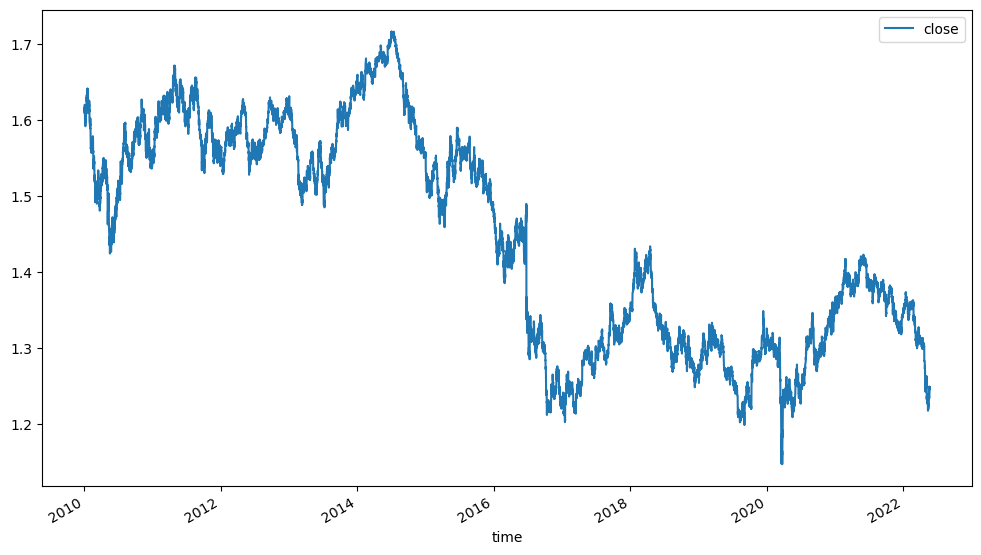

In [6]:
df = data_frame[["close"]]

#plotting dataset to visualize the pattern of prices over the years

df.plot(kind='line',figsize=(12,7))

In [7]:
diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2010 to %d"%(2010 + int(0.8*years)))

Total data: 12 years
80 percent data = 2010 to 2019


In [8]:
df.describe()

,close
count,19270.000000
mean,1.445136
std,0.142216
min,1.147640
25%,1.309480
50%,1.441470
75%,1.572085
max,1.717000


In [9]:
#deduce where the number where the partition should be made 

adjust_data_frame = np.array(data_frame)
x = int(len(data_frame))
split_length = int(x * 0.8)
#You need find the data where the training and testing will be split
split_date = data_frame.index[split_length]




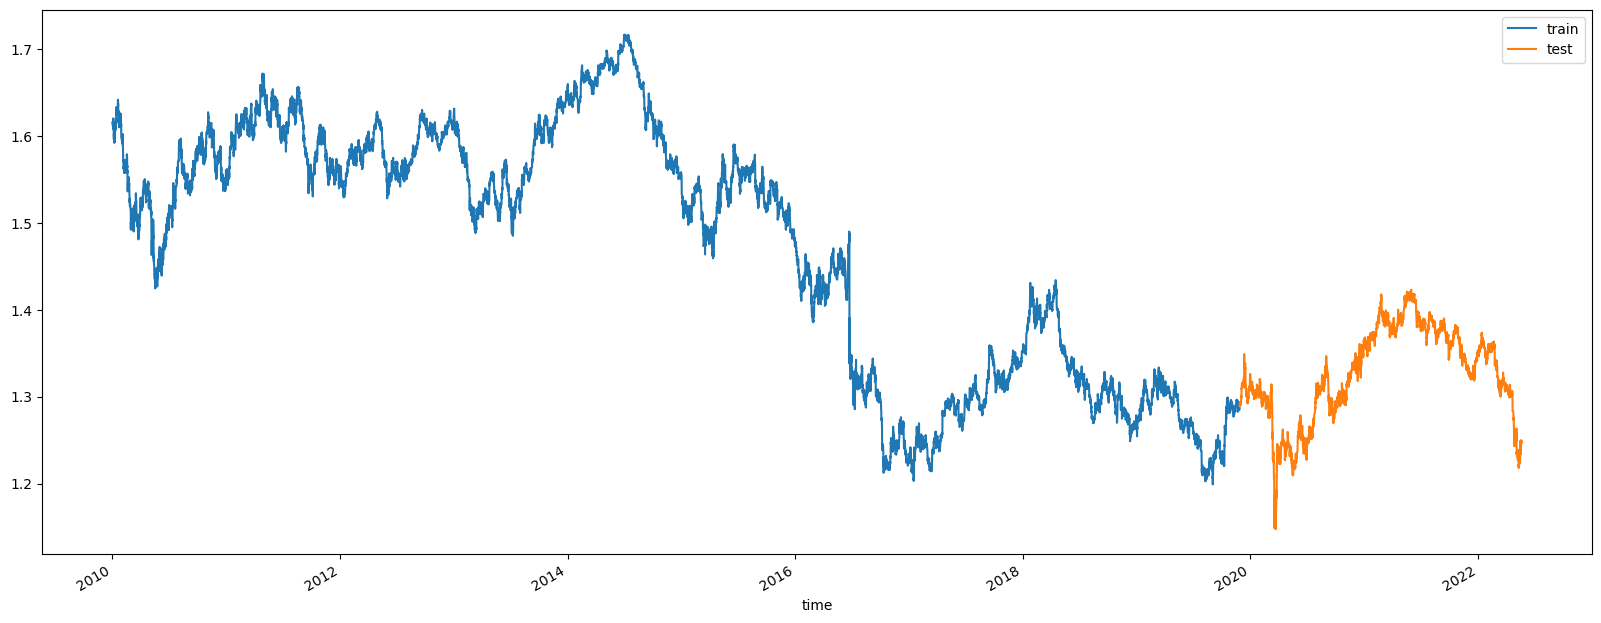

In [10]:
train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(20,8))
test.plot(ax=ax,kind='line',figsize=(20,8))
plt.legend(['train', 'test'])

In [11]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [30]:
X_train = train_sc[:-1]
y_train = train_sc[1:]


X_test = test_sc[:-1]
y_test = test_sc[1:]

In [31]:
X = []
y = []
timesteps = 6

for i in range(timesteps, train.shape[0]):
    X.append(train_sc[i-timesteps:i, 0])
    y.append(train_sc[i, 0])



X = np.array(X)
y = np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(X.shape)
print(y.shape)







(15411, 6, 1)
(15411,)


In [41]:
X_test = []
Y_test = []

for i in range(timesteps, test.shape[0]):
    X_test.append(test_sc[i-timesteps:i, 0])
    Y_test.append(test_sc[i, 0])

    
X_test = np.array(X_test)
Y_test = np.array(Y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))







In [38]:

model_lstm_gru_cnn = tf.keras.Sequential([
    tf.keras.layers.LSTM(104, return_sequences=True, input_shape=(6, 1)),
    tf.keras.layers.GRU(49, return_sequences=True),
    tf.keras.layers.Conv1D(filters=76, kernel_size=4, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='linear')
    ])

model_cnn_cnn = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='linear')
    ])

model_cnn_lstm = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(6, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='linear')
    ])




model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64, activation='relu', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm.add(Dense(1))


model_lstm_gru= Sequential()
model_lstm_gru.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)))
model_lstm_gru.add(LSTM(32, activation='relu',return_sequences=True))
model_lstm_gru.add(LSTM(16, activation='relu',return_sequences=True))
model_lstm_gru.add(GRU(16,  activation='linear', kernel_initializer='lecun_uniform', return_sequences=False))
model_lstm_gru.add(Dense(1))

In [33]:
model_lstm_gru_cnn.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_lstm_gru_cnn = model_lstm_gru_cnn.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
81/81 [==============================] - 3s 9ms/step - loss: 0.1325 - rmse: 0.3641
Epoch 2/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0435 - rmse: 0.2087
Epoch 3/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0221 - rmse: 0.1487
Epoch 4/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0188 - rmse: 0.1371
Epoch 5/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0171 - rmse: 0.1308
Epoch 6/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0166 - rmse: 0.1287
Epoch 7/100
81/81 [==============================] - 1s 10ms/step - loss: 0.0194 - rmse: 0.1393
Epoch 8/100
81/81 [==============================] - 1s 11ms/step - loss: 0.0285 - rmse: 0.1690
Epoch 9/100
81/81 [==============================] - 1s 11ms/step - loss: 0.0579 - rmse: 0.2407
Epoch 10/100
81/81 [==============================] - 1s 11ms/step - loss: 0.0241 - rmse: 0.1552
Epoch 11/100
81/81 [====================

In [34]:
model_cnn_cnn.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_cnn_cnn = model_cnn_cnn.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
81/81 [==============================] - 0s 1ms/step - loss: 0.1369 - rmse: 0.3700
Epoch 2/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0077 - rmse: 0.0876
Epoch 3/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0034 - rmse: 0.0583
Epoch 4/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0021 - rmse: 0.0461
Epoch 5/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0016 - rmse: 0.0402
Epoch 6/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0020 - rmse: 0.0445
Epoch 7/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0030 - rmse: 0.0550
Epoch 8/100
81/81 [==============================] - 0s 1ms/step - loss: 0.0048 - rmse: 0.0694
Epoch 9/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0068 - rmse: 0.0826
Epoch 10/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0064 - rmse: 0.0799
Epoch 10: early stopping


In [35]:
model_cnn_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_cnn_lstm = model_cnn_lstm.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
81/81 [==============================] - 1s 2ms/step - loss: 0.3110 - rmse: 0.5577
Epoch 2/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0171 - rmse: 0.1308
Epoch 3/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0127 - rmse: 0.1128
Epoch 4/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0125 - rmse: 0.1117
Epoch 5/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0114 - rmse: 0.1067
Epoch 6/100
81/81 [==============================] - 0s 3ms/step - loss: 0.0100 - rmse: 0.0999
Epoch 7/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0092 - rmse: 0.0959
Epoch 8/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0091 - rmse: 0.0952
Epoch 9/100
81/81 [==============================] - 0s 3ms/step - loss: 0.0092 - rmse: 0.0957
Epoch 10/100
81/81 [==============================] - 0s 2ms/step - loss: 0.0085 - rmse: 0.0924
Epoch 11/100
81/81 [=============================

In [39]:



model_lstm.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_lstm = model_lstm.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])

model_lstm_gru.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_lstm_gru = model_lstm_gru.fit(X, y, epochs=100, batch_size=192, verbose=1, shuffle=False, callbacks=[early_stop])



Epoch 1/100
81/81 [==============================] - 2s 7ms/step - loss: 0.1663 - rmse: 0.4078
Epoch 2/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0126 - rmse: 0.1125
Epoch 3/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0086 - rmse: 0.0929
Epoch 4/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0059 - rmse: 0.0769
Epoch 5/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0041 - rmse: 0.0642
Epoch 6/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0042 - rmse: 0.0650
Epoch 7/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0055 - rmse: 0.0743
Epoch 8/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0092 - rmse: 0.0961
Epoch 9/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0129 - rmse: 0.1136
Epoch 10/100
81/81 [==============================] - 1s 8ms/step - loss: 0.0069 - rmse: 0.0831
Epoch 10: early stopping
Epoch 1/100
81/81 [=====

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [50]:
y_pred = model_lstm_gru_cnn.predict(X_test)

# Evaluate the performance of your neural network using some commonly used evaluation metrics
mae = mean_absolute_error(Y_test, y_pred)
mse = mean_squared_error(Y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_test, y_pred)

# Print the evaluation metrics
print('Mean Absolute Error: ', mae)
print('Mean Squared Error: ', mse)
print('Root Mean Squared Error: ', rmse)
print('R-squared: ', r2)

121/121 [==============================] - 0s 1ms/step
Mean Absolute Error:  1.0158273059332334
Mean Squared Error:  1.169762614094761
Root Mean Squared Error:  1.081555645399145
R-squared:  -7.112972553633226
